# Ibsen Network Reader 0.1.1

In [1]:
import pandas as pd # PANDAS!
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output # bøkke
import re # Regex
from datetime import datetime # Jeg vet det. Ja, du må faktisk.
output_notebook() # bøkke i notatbok

Loading BokehJS ...

## Cumulative vs point data
Set mode="cumulative" for cumulative plots, and "point" for point plots (per-year etc)

I know that it's jank, but that's how it do rn.

In [2]:
mode="cumulative"
#mode="single"

## Hent data...
...omdøp kolonner, fiks datatypen til noen kolonner.

In [3]:
import glob
paths = []
outputs = []
for path in glob.glob('csv/**/*.csv', recursive=True):
    paths.append(path)
#paths er liste over stier til filer i SRC

for path in paths:
    path = path.replace('csv','output')
    outputs.append(path)
#outputs er liste over stier til nye filer

brev = pd.read_csv(paths[0])
personer = pd.read_csv(paths[1])
dfs = [brev,personer]
for df in dfs:
    df.fillna(0,inplace=True)
personer.columns = ['xmlID', 'wikidata', 'viaf', 'nhrp', 'fornavn', 'etternavn',
       'navn', 'birthday', 'deathday', 'type', 'instance',
       'sex', 'nationality', 'job', 'receiveds',
       'mentions', 'desc', 'partner', 'partnerID']
integers = ['birthday','deathday','receiveds','mentions']
for a in integers:
    personer[a] = personer[a].astype(int)
brev.columns = ['letterID', 'senderID', 'sender', 'recipientID',
       'recipient', 'date', 'dispatch', 'dispatchabbr',
       'geonameID', 'toponymName', 'country', 'lat', 'lon',
       'address', 'location', 'locationabbr',
       'tolat', 'tolon',
       'mentionIDs', 'mentions', 'mentionORGID',
       'mentionORG', 'mentionWorkID', 'mentionWork',
       'textID', 'mentionWorkGenre', 'collectiveversionid',
       'mentionPlaces', 'mentionPlacesabbr']
integers = ['geonameID']
for a in integers:
    brev[a] = brev[a].astype(int)

## DATAVASK: TID OG DATO
Kolonne for dato har rundt 5-6% tjafs. Denne modulen utøver ganske brisk & brutal vold mot irregulære datoer. Den forsøker å finne år-måned-dag, år-måned og år i den rekkefølgen, og legger til så mange 01'er som trengs for å få fullstendige datoer. Noen datoer forklares i tekst (typ "30 november 18XY"), noen er tidsspenn, og andre er bare *???* - disse er per nå alt for irregulære og bare mørbankes til de kun er årstall for å bygges opp igjen.

In [4]:
r = re.compile('^.{4}-.{2}-.{2}$') # Formatet XXXX-XX-XX

good = 0
bad = 0
for x in brev['date']:
    if r.match(x):
        good +=1
    else:
        bad += 1
percA = round((good/len(brev)*100),2)
percB = round((bad/len(brev)*100),2)
print("Registered",good+bad,"out of",len(brev),"entries.\nGood dates:",str(percA)+"% ("+str(good)+")\nBad dates:",
      str(percB)+"% ("+str(bad)+")\n")

i = 0
strings = []
for ting in brev['date']:
    x = ting
    y = re.sub("[^0-9-]", "", x) # Fjern alt som ikke er tall eller bindestrek
    if y == "": # Om dato er TOMT (må fikses med én gang)
        y = "1905-01-01" # da er den fra THE D I S T A N T  F U T U R E  OF  1 9 9 X ! #neida det blir 1905
    if y[0] == "-": # Sjekk at det ikke nå er en bindestrek foran året
        y = y[1:] # Slett den om den finnes
    y = y[:10] # Om resultatet har mer enn 10 karakterer: HØGG
    
    if r.match(y):
        pass
    
        #print("ye:)")
    else:
        if y[0] != "1": # Special case for [1426]. Datoen blir "3041", som jo er litt etter Ibsens tid.
            y = y[3:] # sleng de tre første karakterer ligeledes i søppelet
        #print(i,y)
        if len(y) == 7: # Om det er 7 karakterer (YYYY-MM),
            y+="-01" # Legg til "-01" som dag.
        elif len(y) == 4: # (YYYY)
            y+="-01-01" # Nå er det 1. januar det året
        else: # Om det er hverken 4 eller 7 karakterer og heller ikke 10:
            y = y[:4] # Slett alt som ikke er år
            y+="-01-01" # Nå er det 1. januar det året, ferdig snakka.
        #print(y)
    i += 1
    strings.append(y) # OK

print("Fixing...\n")    
    
good = 0
bad = 0
for x in strings:
    if r.match(x):
        good +=1
    else:
        bad += 1
percA = round((good/len(brev)*100),2)
percB = round((bad/len(brev)*100),2)
print("Done! Good dates:",str(percA)+"% ("+str(good)+"/"+str(len(brev))+")")
if bad > 0:
    print("YOOOO we got some BAD DATES:",
      str(percB)+"% ("+str(bad)+")")
    raise KeyboardInterrupt()
else:
    datetimes = []
    for string in strings:
        x = string.split("-")
        date = x[2]+"/"+x[1]+"/"+x[0] # det her var det ikke noe poeng med, nei
        date_time_obj = datetime.strptime(date, '%d/%m/%Y')
        datetimes.append(date)
    brev['datetimes'] = datetimes
    brev['datetimes'] = pd.to_datetime(brev['datetimes'], format='%d/%m/%Y')
    print("Added column datetimes to df-brev.")
    #brev['datetimes'] = pd.to_datetime(brev["datetimes"].dt.strftime('%d/%m/%Y'))
    brev = brev.sort_values("datetimes")
    brev.reset_index(drop=True,inplace=True)
    personer.reset_index(drop=True,inplace=True)
    personer['xmlID'] = personer['xmlID'].apply(str)

Registered 2409 out of 2409 entries.
Good dates: 94.73% (2282)
Bad dates: 5.27% (127)

Fixing...

Done! Good dates: 100.0% (2409/2409)
Added column datetimes to df-brev.


Index male, female and none IDs for later use. This was previously part of the **big** cell. By preindexing we're making it *lightning fast* in comparison to what it was!

In [5]:
males = []
females = []
others = []
i = 0
for sex in personer['sex']:
    sex = str(sex)
    person = str(personer.iloc[i]['xmlID'])
    if sex == "male": # "male"
        males.append(person)
    elif sex == "female": # "female"
        females.append(person)
    else: # 0
        others.append(person)
    i+=1

## Powercell

In [6]:
datedletters = []
malesaddressed = []
femalesaddressed = []
othersaddressed = []
malesmentioned = []
femalesmentioned = []
othersmentioned = []
anonsaddressed = []
anonsmentioned = []

tomales=0
tofemales=0
toother=0
mentionmales=0
mentionfemales=0
mentionother=0
mentionanons=0
anonsto=0
totalmentions=0
totaladdrs=0
for idx,row in brev.iterrows(): # For HVER rad i brev-df.
    #print(idx)
    if mode != "cumulative":
        tomales=0
        tofemales=0
        toother=0
        anonsto=0
        mentionmales=0
        mentionfemales=0
        mentionother=0
        mentionanons=0
    sex = "LiveLoveLag" # Sett standardverdi for var sex.
    mentioned = row['mentionIDs'] # GET alle mention IDs fra rad.
    date = row['datetimes'] # GET dato fra raden.
    to = row['recipientID'] # GET recipient ID fra raden.
    if to == 0: # hvis TIL er 0:
        print(idx,"TO ER 0")
        pass # Gjør ingenting!
    elif to == "": # hvis TIL er tomt
        print(idx,"TO ER TOM")
        pass # samme.
    else: # Hvis TIL IKKE ER 0:
       # print("Mottaker er ikke tomt")
        if "," in str(to): # Hvis det ER et komma (flere mottakere) i data for mottaker:
           # print("Flere mottakere")
            toArray = to.split(', ') # Splitt mottakerfeltet
            for to in toArray: # For hver innførsel i mottakerfeltet
                totaladdrs+=1
                if str(to) != "0": # Hvis det ikke er 0 her av en eller annen grunn...
                    if to in males:
                        tomales+=1
                    elif to in females:
                        tofemales+=1
                    elif to in others:
                        toother+=1
                    else: # Denne aktiveres aldri
                        anonsto+=1
                    #sex = personer.loc[personer['xmlID'] == str(to)]["sex"].values # GET kjønnet til personen fra personregisteret
                    #sex = str(sex) # stringify
                    #if sex == "['male']": # Hvis MANN
                    #    tomales+=1 # Menn pluss 1
                    #elif sex == "['female']": # Hvis KVINNE
                    #    tofemales+=1 # Kvinner pluss 1
                    #else: # hvis ikke mann ELLER kvinne
                    #    print(to,sex)
                    #    toother+=1 # andre pluss 1
        else: # Hvis det IKKE er et komma i mottakerfeltet
         #   print("Mottaker er alene")
            totaladdrs+=1
            if to in males:
                tomales+=1
            elif to in females:
                tofemales+=1
            elif to in others:
                toother+=1
            else: # Dette betyr altså at sex != male, sex != female... og at tingen ikke har blitt indeksert i other.
                anonsto+=1
            #sex = personer.loc[personer['xmlID'] == str(to)]["sex"].values # GET kjønnet til personen fra personregisteret
            #sex = str(sex) # stringify
            #if sex == "['male']":  # Hvis MANN
            #    tomales+=1 # Menn pluss 1
            #elif sex == "['female']": # Hvis KVINNE
            #    tofemales+=1 # Kvinner pluss 1
            #else: # ELLERS
            #    #print(to,sex)
            #    toother+=1 # andre pluss 1
            
    if mentioned == 0: # Hvis MENTIONS er 0 (N/A)
        #print("Mention er 0")
        pass # Gjør ingenting
    elif mentioned == "": # Hvis mentions er TOM (N/A)
        #print("Mention er null")
        pass # Samme.
    else: # Hvis det er data i feltet for MENTIONS
       # print("Mention har data")
        if "," in mentioned: # HVIS det er et komma i feltet
            mentioned = mentioned.split(', ') # Splitt det
            for mention in mentioned: # For hver av elementene i arrayen
                totalmentions+=1
            #    sex = personer.loc[personer['xmlID'] == mention]["sex"].values # Hent kjønn
            #    sex = str(sex) # Bla bla bla - det samme som over.
            #    if sex == "['male']":
            #        mentionmales+=1
            #    elif sex == "['female']":
            #        mentionfemales+=1
            #    else:
            #        mentionother+=1
                if mention in males:
                    mentionmales+=1
                elif mention in females:
                    mentionfemales+=1
                elif mention in others:
                    mentionother+=1
                else:
                    mentionanons+=1
        else: # Hvis det er ÉN person i feltet, hent dennes verdier fra personregisteret
            totalmentions+=1
            if mention in males:
                mentionmales+=1
            elif mention in females:
                mentionfemales+=1
            elif mention in others:
                mentionother+=1
            else:
                mentionanons+=1
          #  sex = personer.loc[personer['xmlID'] == mention]["sex"].values
          #  sex = str(sex)
          #  if sex == "['male']":
          #      mentionmales+=1
          #  elif sex == "['female']":
          #      mentionfemales+=1
          #  else:
          #      mentionother+=1
    datedletters.append(date)
    malesaddressed.append(tomales)
    femalesaddressed.append(tofemales)
    othersaddressed.append(toother)
    malesmentioned.append(mentionmales)
    femalesmentioned.append(mentionfemales)
    othersmentioned.append(mentionother)
    anonsaddressed.append(anonsto)
    anonsmentioned.append(mentionanons)
    #print("\n")
#print(tomales,tofemales,toother," | ",mentionmales,mentionfemales,mentionother)
df = pd.DataFrame(
    {'date': datedletters,
     'males_addressed': malesaddressed,
     'females_addressed': femalesaddressed,
     'others_addressed': othersaddressed,
     'anons_addressed':anonsaddressed,
     'males_mentioned': malesmentioned,
     'females_mentioned': femalesmentioned,
     'others_mentioned': othersmentioned,
     'anons_mentioned':anonsmentioned
    })
df

12 TO ER 0


,date,males_addressed,females_addressed,others_addressed,anons_addressed,males_mentioned,females_mentioned,others_mentioned,anons_mentioned
0,1844-05-20,1,0,0,0,5,1,0,0
1,1844-10-06,0,1,0,0,1,1,0,0
2,1845-08-01,0,1,0,0,0,0,0,0
3,1846-12-07,1,0,0,0,4,0,0,0
4,1849-10-15,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2404,1904-09-01,0,0,1,0,0,0,0,0
2405,1905-01-01,0,0,0,1,0,0,0,0
2406,1905-01-01,1,0,0,0,0,0,0,0
2407,1905-03-17,1,0,0,0,0,0,0,0


~~1857 257 40 | 3130 943 0?~~
1857 257 189 | 3130 943 0?
>:|

Personfilen angir tallene over som (kumulativt) (addr.|ment.) M1852, F260, O203  |  M3562 F1073 O0. Se under...

1. Oops. Liten skriveleif førte til at others_addressed ble veldig lavt. Fikset nå til 189.

In [7]:
personer.groupby("sex").sum()

,birthday,deathday,receiveds,mentions
sex,,,,
0,0,0,203,0
female,547735,526664,260,1073
male,2206445,2246475,1852,3562


In [8]:
print(totaladdrs,totalmentions) # Hvor mange mottakere og nevnte personer skriptet henter

2420 4113


In [9]:
totaladdrs2=0
totalmentions2=0
for recs in personer['receiveds']:
    totaladdrs2+=recs
for mens in personer['mentions']:
    totalmentions2+=mens

In [10]:
print(totaladdrs2,totalmentions2) # Hvor mange mottakere og nevnte personer personregisteret hevder det er

2315 4635


Daaaa er det nok noe som er feil et sted. Enten har brevfilen ikke alle brev, eller så har personregisteret feil, eller so har ikke brevfilen alle mentions.

In [11]:
%matplotlib inline

<AxesSubplot:xlabel='date'>

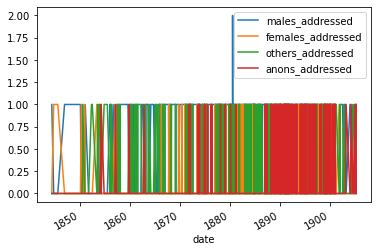

In [12]:
df.plot(x="date", y=["males_addressed", "females_addressed", "others_addressed","anons_addressed"])

In [13]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.layouts import column
#from bokeh.sampledata.commits import data
from bokeh.io import export_png
from bokeh.transform import jitter
title = "Ibsen's outgoing letters by gender"
if mode=="cumulative":
    title += ", cumulative view"
else:
    title += ", per-letter view"
title1 = title+" - Addressed to."
title2 = title+" - Mentioning."
source = ColumnDataSource(df)

p = figure(width=800, height=400, x_axis_type='datetime',
           title=title1)

p.scatter(x='date', y=jitter('males_addressed', width=2, range=p.y_range), color='blue',  source=source, alpha=0.3, legend_label="Men")
p.scatter(x='date', y=jitter('females_addressed', width=2, range=p.y_range), color='hotpink',  source=source, alpha=0.3, legend_label="Women")
p.scatter(x='date', y=jitter('others_addressed', width=2, range=p.y_range), color='green',  source=source, alpha=0.3, legend_label="N/A (Organizations)")
p.scatter(x='date', y=jitter('anons_addressed', width=2, range=p.y_range), color='grey',  source=source, alpha=0.3, legend_label="N/A (Unknown)")

#p.xaxis.formatter.days = ['%Y']
p.x_range.range_padding = 0
#p.ygrid.grid_line_color = None

d = figure(width=800, height=400, x_axis_type='datetime',
           title=title2)

d.scatter(x='date', y=jitter('males_mentioned', width=2, range=p.y_range), color='blue',
          source=source, alpha=0.3, legend_label="Men")
d.scatter(x='date', y=jitter('females_mentioned', width=2, range=p.y_range), color='hotpink', 
          source=source, alpha=0.3, legend_label="Women")
d.scatter(x='date', y=jitter('others_mentioned', width=2, range=p.y_range), color='green',
          source=source, alpha=0.3, legend_label="N/A (Organizations)")
d.scatter(x='date', y=jitter('anons_mentioned', width=2, range=p.y_range), color='grey',
          source=source, alpha=0.3, legend_label="N/A (Unknown)")
#p.xaxis.formatter.days = ['%Y']
p.x_range.range_padding = 0
d.x_range.range_padding = 0
#p.ygrid.gridS_line_color = None

p.legend.location = "top_left"
p.legend.click_policy="hide"

d.legend.location = "top_left"
d.legend.click_policy="hide"

show(column(p, d))
if mode=="cumulative":
    export_png(column(p, d), filename="Cumulative.png")

In [14]:
if mode=="cumulative":
    print("Cannot render these plots in cumulative mode, you'll have to run it again.")
    raise KeyboardInterrupt
        
df1 = df
lst = []
lst1 = []
for y in df1['date']:
    y = y.strftime("%Y/%m/%d")
    z = y[:4]
    lst.append(z)
    x = y[5:7]
    lst1.append(x)
df1['year'] = lst
df1['month'] = lst1
#df1 = df1.sort_values('month')
integers = ['males_addressed',
     'females_addressed',
     'others_addressed',
     'anons_addressed',
     'males_mentioned',
     'females_mentioned',
     'others_mentioned',
     'anons_mentioned']
for a in integers:
    df1[a] = df1[a].astype(int)
#df1.groupby(['year', 'month'])['males_addressed'].agg('sum')
df2 = df1.groupby(['year']).sum() # what the goddamn is going on with the maths here??
df2 = df2.reset_index()

df2['date'] = df2['year']


df2['date'] = pd.to_datetime(df2['date'])

df2

,year,males_addressed,females_addressed,others_addressed,anons_addressed,males_mentioned,females_mentioned,others_mentioned,anons_mentioned,date
0,1844,1,1,0,0,6,2,0,0,1844-01-01
1,1845,0,1,0,0,0,0,0,0,1845-01-01
2,1846,1,0,0,0,4,0,0,0,1846-01-01
3,1849,1,0,0,0,1,0,0,0,1849-01-01
4,1850,3,2,1,0,11,1,0,0,1850-01-01
5,1851,1,0,0,0,1,0,0,0,1851-01-01
6,1852,0,0,5,0,39,3,0,0,1852-01-01
7,1853,1,3,4,0,12,4,0,0,1853-01-01
8,1854,0,0,2,2,2,0,0,0,1854-01-01
9,1855,0,0,1,0,1,0,0,0,1855-01-01


In [15]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.layouts import column

#from bokeh.sampledata.commits import data
from bokeh.transform import jitter
title = "Ibsen's outgoing letters by gender, summed per full year"
title1 = title+" - Addressed to."
title2 = title+" - Mentioning."
source = ColumnDataSource(df2)

p = figure(width=800, height=400, x_axis_type='datetime',
           title=title1)

p.scatter(x='date', y='males_addressed', color='blue',  source=source, alpha=0.6, legend_label="Men")
p.scatter(x='date', y='females_addressed', color='hotpink',  source=source, alpha=0.6, legend_label="Women")
p.scatter(x='date', y='others_addressed', color='green',  source=source, alpha=0.3, legend_label="N/A (Organizations)")
p.scatter(x='date', y='anons_addressed', color='grey',  source=source, alpha=0.3, legend_label="N/A (Unknown)")

p.line(x='date', y='males_addressed', color='blue',  source=source, alpha=0.6, legend_label="Men")
p.line(x='date', y='females_addressed', color='hotpink',  source=source, alpha=0.6, legend_label="Women")
p.line(x='date', y='others_addressed', color='green',  source=source, alpha=0.3, legend_label="N/A (Organizations)")
p.line(x='date', y='anons_addressed', color='grey',  source=source, alpha=0.3, legend_label="N/A (Unknown)")
p.x_range.range_padding = 0
#p.ygrid.grid_line_color = None

d = figure(width=800, height=400, x_axis_type='datetime',
           title=title2)

d.scatter(x='date', y='males_mentioned', color='blue',
          source=source, alpha=0.6, legend_label="Men")
d.scatter(x='date', y='females_mentioned', color='hotpink', 
          source=source, alpha=0.6, legend_label="Women")
d.scatter(x='date', y='others_mentioned', color='green',
          source=source, alpha=0.3, legend_label="N/A (Organizations)")
d.scatter(x='date', y='anons_mentioned', color='grey',
          source=source, alpha=0.3, legend_label="N/A (Unknown)")

d.line(x='date', y='males_mentioned', color='blue',
          source=source, alpha=0.6, legend_label="Men")
d.line(x='date', y='females_mentioned', color='hotpink', 
          source=source, alpha=0.6, legend_label="Women")
d.line(x='date', y='others_mentioned', color='green',
          source=source, alpha=0.3, legend_label="N/A (Organizations)")
d.line(x='date', y='anons_mentioned', color='grey',
          source=source, alpha=0.3, legend_label="N/A (Unknown)")
#p.xaxis.formatter.days = ['%Y']
p.x_range.range_padding = 0
d.x_range.range_padding = 0
#p.ygrid.gridS_line_color = None

p.legend.location = "top_left"
p.legend.click_policy="hide"

d.legend.location = "top_left"
d.legend.click_policy="hide"

show(column(p, d))
export_png(column(p, d), filename="ByYear.png")

'C:\\Users\\lokes\\Programming\\INR\\ByYear.png'